# HotSpots Starter Notebook

This notebook should help you get started with the Hotspots competition on Zindi. In it we cover:
- Loading the data
- Simple EDA and an example of feature enginnering
- Suggestions for validation split
- Creating a simple model
- Making a submission
- Some tips for improving your score


# Setup

Load the data for the competition.

In [ ]:
'''
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt
'''

'\nimport pandas as pd\nfrom sklearn.linear_model import RidgeCV\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.metrics import mean_squared_error, r2_score\nfrom matplotlib import pyplot as plt\n'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
#from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/hotspot_data"

SampleSubmission.csv  test.csv	train.csv  VariableDefinitionsHotspot.csv


In [ ]:
!cp 'drive/My Drive/hotspot_data/train.csv' train.csv
!cp 'drive/My Drive/hotspot_data/test.csv' test.csv
!cp 'drive/My Drive/hotspot_data/SampleSubmission.csv' ss.csv

In [ ]:
train = pd.read_csv('train.csv', parse_dates=['date'])
train.head()

,ID,area,date,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,climate_srad,climate_swe,climate_tmmn,climate_tmmx,climate_vap,climate_vpd,climate_vs,elevation,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,population_density,precipitation
0,0_2000-04-01,0,2000-04-01,25.447,5.296,0.003688,1250.622712,0.0,-178.916305,1250.622712,158.387765,8.000000,498.913776,2143.430034,0.0,206.935453,323.873675,2508.795159,115.989282,129.825024,590.564102,0.0,0.0,0.350169,0.0,0.649524,0.0,0.000307,0.0,0.0,2.214262,0.198996
1,1_2000-04-01,1,2000-04-01,25.669,5.293,0.000000,1238.019166,0.0,-150.779947,1238.019166,164.645065,8.104576,590.346191,2132.253953,0.0,204.835170,321.838884,2500.432319,112.619789,129.471370,611.544277,0.0,0.0,0.429049,0.0,0.570644,0.0,0.000307,0.0,0.0,3.833042,0.188071
2,2_2000-04-01,2,2000-04-01,25.443,5.074,0.000000,1240.449964,0.0,-200.503858,1240.449964,163.699542,8.027851,536.613938,2139.632626,0.0,207.001206,321.846757,2519.259344,112.378707,127.550639,594.188987,0.0,0.0,0.238300,0.0,0.761700,0.0,0.000000,0.0,0.0,1.927303,0.211730
3,3_2000-04-01,3,2000-04-01,25.665,5.070,0.000000,1229.240077,0.0,-177.011032,1229.240077,172.996043,8.820002,648.271615,2125.206979,0.0,204.127473,319.348123,2493.392613,109.132390,131.703082,645.362481,0.0,0.0,0.488146,0.0,0.511854,0.0,0.000000,0.0,0.0,1.878281,0.215403
4,4_2000-04-01,4,2000-04-01,25.886,5.067,0.000307,1224.093679,0.0,-153.256111,1224.093679,178.396749,9.000000,719.423119,2114.709813,0.0,203.295123,318.639735,2487.984467,108.161469,133.354846,660.372381,0.0,0.0,0.322243,0.0,0.677757,0.0,0.000000,0.0,0.0,1.968818,0.199975


In [ ]:
train.shape

(626644, 32)

In [ ]:
test = pd.read_csv('test.csv', parse_dates=['date'])
test.head(1)

,ID,area,date,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,climate_srad,climate_swe,climate_tmmn,climate_tmmx,climate_vap,climate_vpd,climate_vs,elevation,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,population_density,precipitation
0,0_2014-01-01,0,2014-01-01,25.447,5.296,0,142.756021,1217.92618,-953.401012,1360.571291,1.0,0.0,355.59369,2349.499157,0.0,187.541787,332.578998,2542.124518,111.013969,156.563945,590.564102,0.0,0.0,0.430648,0.0,0.569045,0.0,0.000307,0.0,0.0,2.773423,0.000457


In [ ]:
#Check for existing null values
train.isnull().sum() 

ID                        0
area                      0
date                      0
lat                       0
lon                       0
burn_area                 0
climate_aet               0
climate_def               0
climate_pdsi              0
climate_pet               0
climate_pr                0
climate_ro                0
climate_soil              0
climate_srad              0
climate_swe               0
climate_tmmn              0
climate_tmmx              0
climate_vap               0
climate_vpd               0
climate_vs                0
elevation                 0
landcover_0               0
landcover_1               0
landcover_2               0
landcover_3               0
landcover_4               0
landcover_5               0
landcover_6               0
landcover_7               0
landcover_8               0
population_density    19516
precipitation             0
dtype: int64

In [ ]:
#Fill Nan values using median
train.fillna(train.median(), inplace=True)

# EDA + Feature Engineering

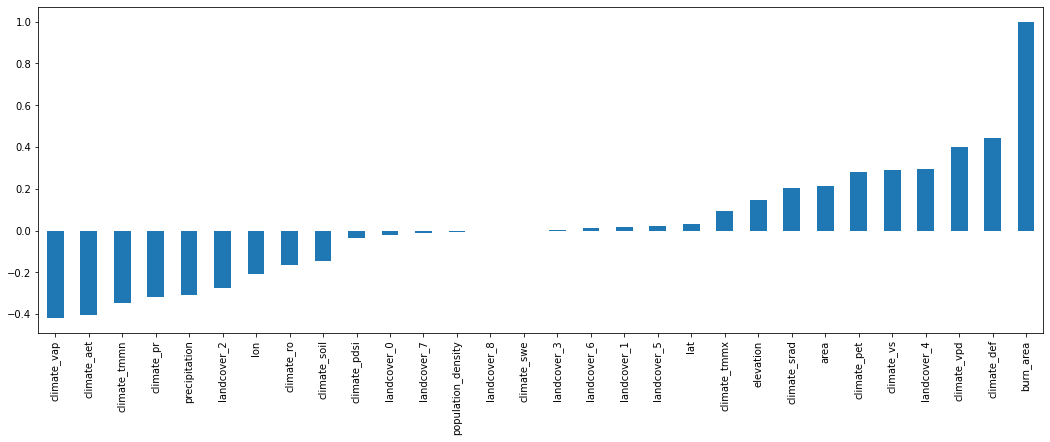

In [ ]:
# Look at correlation with target
train.corr()['burn_area'].sort_values().plot(kind='bar', figsize=(18, 6))

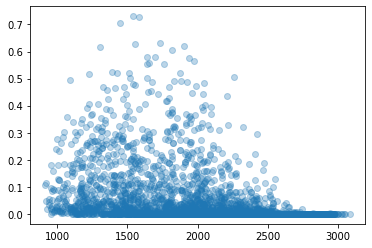

In [ ]:
# Look at some scatter plots (only plotting for a subset of data to keep things fast)
sample = train.sample(10000)
plt.scatter(sample['climate_vap'], sample['burn_area'], alpha=0.3)

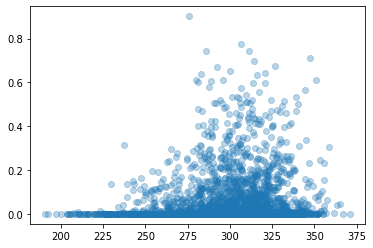

In [ ]:
# Higher temp -> more fires it looks like
plt.scatter(sample['climate_tmmx'], sample['burn_area'], alpha=0.3)

##  Adding date features

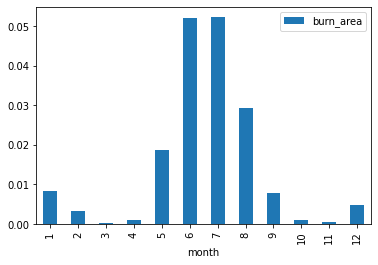

In [ ]:
# Date variables
train['month'] = train.date.dt.month
train['year'] = train.date.dt.year

# Plotting mean burn_area for each month - very strong mid-year peak (dry season)
train.groupby('month').mean().reset_index().plot(y='burn_area', x='month', kind='bar')

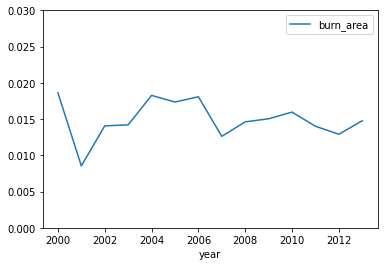

In [ ]:
# Plot trend year-on-year
train.groupby('year').mean().reset_index().plot(y='burn_area', x='year', ylim=(0, 0.03))

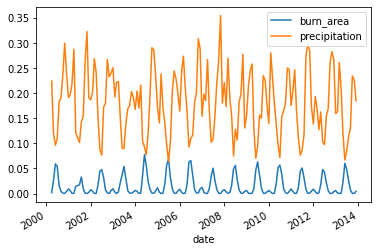

In [ ]:
# Let's plot precipitation and burn area on the same plot - note the inverse relationship, and the strong periodic component to both.
ax = train.groupby('date').mean().reset_index().plot(y='burn_area', x='date')
train.groupby('date').mean().reset_index().plot(y='precipitation', x='date', ax=ax)

## Adding more features - some ideas




*   Read the list of climate variables and what they mean. See if you can combine them in interesting ways - perhaps a 'hot_and_dry' metric...
*   Fire depends on some processes that take a long time - for example, there may be more fuel if the previous growing season was a good one. Consider some lagged variables to give the model some inputs for what came before the current month.
*   Make some categorical features - 'dominant_land_type' or 'is_peak_rainfall'. 
*   ...



# Data Split for Validation

We don't want to just split randomly - this would give us artificially high scores. Instead, let's use the last 3 years of the dataset for validation to more closely match the test configuration.

In [ ]:
train_all = train.copy().dropna()
train = train_all.loc[train_all.date < '2011-01-01']
valid = train_all.loc[train_all.date > '2011-01-01']
train = train_all[:len(train_all)//10]
valid = train_all[:len(train_all)//10]
print(train.shape, valid.shape)

(62664, 34) (62664, 34)


# Simple Model

In [ ]:
# Define input and output columns
in_cols = train.columns[6:]
target_col = 'burn_area'
in_cols

Index(['climate_aet', 'climate_def', 'climate_pdsi', 'climate_pet',
       'climate_pr', 'climate_ro', 'climate_soil', 'climate_srad',
       'climate_swe', 'climate_tmmn', 'climate_tmmx', 'climate_vap',
       'climate_vpd', 'climate_vs', 'elevation', 'landcover_0', 'landcover_1',
       'landcover_2', 'landcover_3', 'landcover_4', 'landcover_5',
       'landcover_6', 'landcover_7', 'landcover_8', 'population_density',
       'precipitation', 'month', 'year'],
      dtype='object')

In [ ]:
# Get our X and y training and validation sets ready
X_train, y_train = train[in_cols], train[target_col]
X_valid, y_valid = valid[in_cols], valid[target_col]

In [ ]:
#Create array of models to evaluate
models = []
models.append(('LiR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('ElasticNet', ElasticNet()))
models.append(('Bag_Re', BaggingRegressor()))
models.append(('RandomForest', RandomForestRegressor(n_estimators=10)))
models.append(('ExtraTreesRegressor', ExtraTreesRegressor(n_estimators=10)))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVM', SVR()))

# Evaluations
results = []
names = []
scoring = []

for name, model in models:
    # Fit the model
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_valid)
    
    # Evaluate the model
    score = mean_squared_error(y_valid, predictions)**0.5
    #mae = mean_absolute_error(predictions, Y)
    # print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    results.append(score)
    names.append(name)
    
    msg = "%s: %f " % (name, score)
    print(msg)
    

LiR: 0.052156 
Ridge: 0.052158 
Lasso: 0.053892 
ElasticNet: 0.053957 


KeyboardInterrupt: ignored

In [ ]:
%%time
# Create and fit the model
model = ExtraTreesRegressor(n_estimators=50)
model.fit(X_train, y_train)

# Make predictions
preds = model.predict(X_valid)

# Score
mean_squared_error(y_valid, preds)**0.5 # RMSE - should match Zindi score. Lower is better

CPU times: user 2min 25s, sys: 429 ms, total: 2min 25s
Wall time: 2min 26s


# Making A Submission

Once you've got some features and a model you're happy with, it's time to submit!

In [ ]:
# Look at the sample submission file
ss = pd.read_csv('ss.csv')
ss.head()

,ID,Prediction
0,0_2014-01-01,0
1,1_2014-01-01,0
2,2_2014-01-01,0
3,3_2014-01-01,0
4,4_2014-01-01,0


In [ ]:
# And the test data
test.head()

,ID,area,date,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,climate_srad,climate_swe,climate_tmmn,climate_tmmx,climate_vap,climate_vpd,climate_vs,elevation,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,population_density,precipitation
0,0_2014-01-01,0,2014-01-01,25.447,5.296,0,142.756021,1217.926180,-953.401012,1360.571291,1.000000,0.0,355.593690,2349.499157,0.0,187.541787,332.578998,2542.124518,111.013969,156.563945,590.564102,0.0,0.0,0.430648,0.0,0.569045,0.0,0.000307,0.0,0.0,2.773423,0.000457
1,1_2014-01-01,1,2014-01-01,25.669,5.293,0,154.836847,1193.866315,-961.703043,1348.688788,1.000000,0.0,382.206636,2340.597389,0.0,185.895903,330.826066,2551.085649,106.576545,158.165429,611.544277,0.0,0.0,0.494624,0.0,0.505068,0.0,0.000307,0.0,0.0,4.697883,0.000129
2,2_2014-01-01,2,2014-01-01,25.443,5.074,0,127.790933,1223.640222,-962.435857,1351.521823,1.000000,0.0,318.078852,2351.867856,0.0,188.441645,330.077285,2551.183265,107.104292,153.257656,594.188987,0.0,0.0,0.288343,0.0,0.711657,0.0,0.000000,0.0,0.0,2.488614,0.000398
3,3_2014-01-01,3,2014-01-01,25.665,5.070,0,136.924571,1201.258784,-961.326298,1338.120278,1.000000,0.0,339.386497,2348.509414,0.0,185.393692,326.942319,2539.815326,101.962346,155.518048,645.362481,0.0,0.0,0.492103,0.0,0.507897,0.0,0.000000,0.0,0.0,2.439959,0.000158
4,4_2014-01-01,4,2014-01-01,25.886,5.067,0,144.278146,1197.831547,-959.248284,1342.118844,0.998555,0.0,358.043829,2341.881156,0.0,186.275015,327.839976,2549.462252,102.743046,159.865021,660.372381,0.0,0.0,0.333855,0.0,0.666145,0.0,0.000000,0.0,0.0,2.546723,0.000153


In [ ]:
# So we need to predict the burn area for each row in test. 
 
# Add the same features to test as we did to train:
test['month'] = test.date.dt.month
test['year'] = test.date.dt.year
 
# Get predictions
preds = model.predict(test[in_cols].fillna(0)) # fillna(0) here could be improved by examining the missing data and filling more appropriately.
 
# Add to submission dataframe
ss['Prediction'] = preds
 
# View
ss.head()

,ID,Prediction
0,0_2014-01-01,0.188498
1,1_2014-01-01,0.158908
2,2_2014-01-01,0.276794
3,3_2014-01-01,0.222962
4,4_2014-01-01,0.285927


In [ ]:
# Save ready for submission:
ss.to_csv('starter_submission.csv', index=False)

# Tips for improving your score

- Once you've chosen a model, you should re-train it on all the data (including that which you previously held back for validation) to give it the best chance of succeeding
- There is a timeseries component to this challenge. Think about how to use this to improve your accuracy.
- Spend some time on feature engineering. Since no external data is allowed for this challenge, the winning solution will be the one that gets the most out of the data provided.